In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

In this notebook we experiment with the error between a discrete time algorithm (DTA), the extra-gradient method, and the so-called $O(s^r)$-ODEs that we derive from it.

Given a loss $l: R \times R \to R$ we want to find $$\min_x \max_y l(x,y).$$ 
With slight abuse of notation, we set $F(z) = (\nabla_x l(x,y), -\nabla_y l(x,y)).$
The minus in the definition of $F$ is very important.

For extra-gradient an iteration with step-size $s$ is given by: $$z_{n+1} = z_n - sF(z_n - sF(z_n))$$
Its O(1)-ODE is gradient flow (GF): $$\dot z(t) = -F(z).$$
Adding the next term like in the procedure described in the Lu paper gives the O(s)-ODE $$\dot z(t) = -F(z) + \frac{s}{2} \nabla F(z) F(z).$$
For this simulation we only go up to the O(s^2)-ODE which is 
$$ \dot z(t) = -F(z) + \frac{s}{2} \nabla F(z) F(z) + s^2 \left(\frac{2}{3} \big(\nabla F(z)\big)^2 F(z) - \frac{1}{12}\nabla^2 F(z) \big(F(z), F(z)\big)\right)$$


In [2]:
def trajectory_dta(algo, flow, z0, lr=1e-2, numsteps=100000):
    """This runs a given algorithm for a certain number of steps and returns all
    the iterates"""
    z0 = np.array(z0)
    zs = [z0]
    for t in range(int(numsteps)):
        z = zs[-1]
        new_z = algo(z, flow, lr)
        zs.append(new_z)
    return np.array(zs)


In [3]:
def F(z):
    """Flow given by loss l(x,y) = xy"""
    return np.array([z[1], -z[0]])


def nFz(z):
    """Nabla (Jacobian) of previous flow"""
    return np.array([[0, 1], [-1, 0]])


def eg_os2ode(z, t, flow, n_flow, n2_flow, s):
    """O(s^2)-ode of extra-gradient method"""
    # calculate s2 tensor product
    s2_tens = np.empty((len(z)))
    for i in range(len(z)):
        for j in range(len(z)):
            for k in range(len(z)):
                flow_z = flow(z)
                s2_tens[i] += n2_flow(z)[i,j,k] * flow_z[j] * flow_z[k]
    # calculate s2 term
    s2_term = 2/3 * n_flow(z).dot(n_flow(z)).dot(flow(z)) - 1/12 * s2_tens

    return -flow(z) + s / 2.0 * n_flow(z).dot(flow(z)) + s**2 * s2_term


def eg_os1ode(z, t, flow, nabla_flow, s):
    """O(s^1)-ode of extra-gradient method"""
    return -flow(z) + s / 2.0 * nabla_flow(z).dot(flow(z))


def eg_os0ode(z, t, flow, nabla_flow, s):
    """O(s^0)-ode of extra-gradient method"""
    return -flow(z)


def eg_dta(z, flow, s, nabla_flow=None):
    """The discrete time algorithm: extra-gradient method"""
    return z - s * flow(z - s * flow(z))


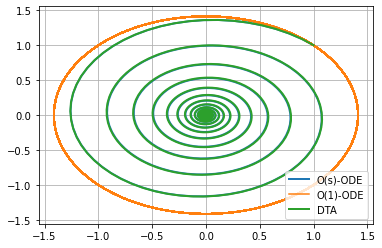

In [4]:
from scipy.integrate import odeint

# Using scipy's differential equation solver to plot the trajectory of the
# differential equation
z_egode1 = odeint(eg_os1ode, [1, 1], np.linspace(0, 1001, 10001), args=(F, nFz, 1e-1))
z_egode0 = odeint(eg_os0ode, [1, 1], np.linspace(0, 1001, 10001), args=(F, nFz, 1e-1))
z_egdta = trajectory_dta(eg_dta, F, [1.0, 1.0], lr=1e-1)

# Creating the plot
fig, ax = plt.subplots()
ax.plot(z_egode1[:, 0], z_egode1[:, 1], linewidth=2.0, label="O(s)-ODE")
ax.plot(z_egode0[:, 0], z_egode0[:, 1], label="O(1)-ODE")
ax.plot(z_egdta[:, 0], z_egdta[:, 1], linewidth=2.0, label="DTA")
plt.grid(visible=True)
ax.legend()
plt.show()
# fig.savefig("xyloss_traj.png", dpi=80, bbox_inches="tight")


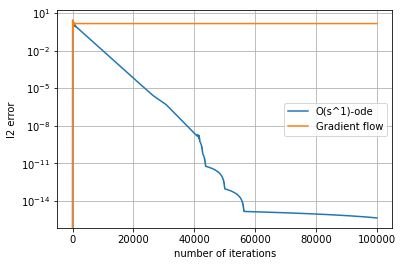

In [5]:
# Get index to sample ODE at uniform intervals
# This actually doesn't matter because for simplicity's sake we end up sampling
# the same number of points from the ODEs and the DTA. 
# Actually,
# This may be why the O(s^2)-ODE doesn't give an improvement in one of the last
# plots, we need a better way to calculate the "error" between a curve (the ODE)
# and a set of points (the DTA)
idx = np.linspace(0, len(z_egode1) - 1, num=len(z_egdta)).astype(int)

# Calculating the error
diff1 = np.sqrt(((z_egdta - z_egode1[idx]) ** 2).sum(axis=1))
diff0 = np.sqrt(((z_egdta - z_egode0[idx]) ** 2).sum(axis=1))

# Creating the plots
fig, ax = plt.subplots()
ax.plot(np.arange(len(diff1)), diff1, label="O(s^1)-ode")
ax.plot(np.arange(len(diff0)), diff0, label="Gradient flow")
ax.set_yscale("log")
ax.legend()
plt.grid(visible=True)
ax.set_ylabel("l2 error")
ax.set_xlabel("number of iterations")

# fig.savefig("xyloss_osr.png", dpi=80, bbox_inches="tight")

In [6]:
def G(z):
    """This flow doesn't come from any loss it was just a random experiment"""
    return np.array([z[1] ** 3, -z[0] ** 3])


def n_G(z):
    """Nabla of previous flow"""
    return np.array([[0, 3 * z[1] ** 2], [-3 * z[0] ** 2, 0]])


def n2_G(z):
    """Second nabla of previous flow"""
    return np.array([[[0, 0], [-6 * z[0], 0]], [[0, 6 * z[1]], [0, 0]]])


In [7]:
# Using G flow
s = 1e-1
z_egode2 = odeint(eg_os2ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, n2_G, s))
z_egode1 = odeint(eg_os1ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, s))
z_egode0 = odeint(eg_os0ode, [1, 1], np.linspace(0, 100, 10001), args=(G, n_G, s))
z_egdta  = trajectory_dta(eg_dta, G, [1,1], lr=s)

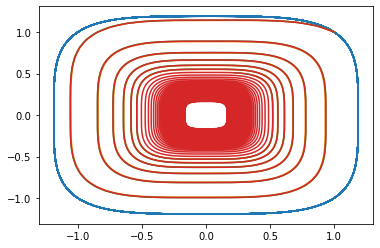

In [8]:
# Interesting square-looking spiral
fig, ax = plt.subplots()
ax.plot(z_egode0[:,0], z_egode0[:,1])
ax.plot(z_egode1[:,0], z_egode1[:,1])
ax.plot(z_egode2[:,0], z_egode2[:,1])
ax.plot(z_egdta[:,0], z_egdta[:,1])

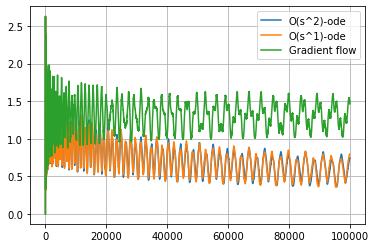

In [9]:

# Again plotting the erorrs between different ODEs and 
diff2 = np.sqrt(((z_egdta - z_egode2[idx]) ** 2).sum(axis=1))
diff1 = np.sqrt(((z_egdta - z_egode1[idx]) ** 2).sum(axis=1))
diff0 = np.sqrt(((z_egdta - z_egode0[idx]) ** 2).sum(axis=1))

fig, ax = plt.subplots()
ax.plot(np.arange(len(diff2)), diff2, label="O(s^2)-ode")
ax.plot(np.arange(len(diff1)), diff1, label="O(s^1)-ode")
ax.plot(np.arange(len(diff0)), diff0, label="Gradient flow")
# ax.set_yscale("log")
ax.legend()
plt.grid(visible=True)
# fig.savefig("cubeloss_osr.png", dpi=80, bbox_inches="tight")

In [10]:

def H(z):
    """This is the flow derived from the loss l(x,y) = x^3 * y^3"""
    x = z[0]
    y = z[1]
    return np.array([y**3 * x**2, -x**3 * y**2])


def n_H(z):
    """Nabla (Jacobian) of the above flow"""
    x = z[0]
    y = z[1]
    return np.array([[2 * y**3 * x, 3 * y**2 * x**2], [-3 * x**2 * y**2, -2 * x**3 * y]])


def n2_H(z):
    """Second nabla of of the above flow, this actually returns a tensor"""
    x = z[0]
    y = z[1]
    return np.array([
        [[2 * y**3, 6 * y**2 * x], [-6 * y**2 * x, -6 * x**2 * y]],
        [[6 * y**2 * x, 6 * y * x**2], [-6 * y * x**2, -2 * x**3]]
        ])

In [11]:
# Using H loss
s = 1e-1
z_egode2 = odeint(eg_os2ode, [1, 1], np.linspace(0, 100, 10001), args=(H, n_H, n2_H, s))
z_egode1 = odeint(eg_os1ode, [1, 1], np.linspace(0, 100, 10001), args=(H, n_H, s))
z_egode0 = odeint(eg_os0ode, [1, 1], np.linspace(0, 100, 10001), args=(H, n_H, s))
z_egdta  = trajectory_dta(eg_dta, H, [1,1], lr=s)

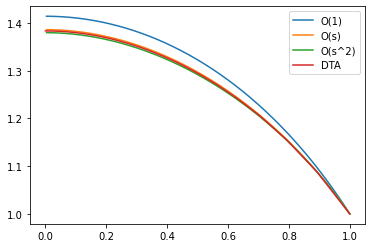

In [12]:

fig, ax = plt.subplots()
ax.plot(z_egode0[:,0], z_egode0[:,1], label="O(1)")
ax.plot(z_egode1[:,0], z_egode1[:,1], label="O(s)")
ax.plot(z_egode2[:,0], z_egode2[:,1], label="O(s^2)")
ax.plot(z_egdta[:,0], z_egdta[:,1], label="DTA")
ax.legend()
fig.savefig("actual_cubeloss_traj.png", dpi=80, bbox_inches="tight")

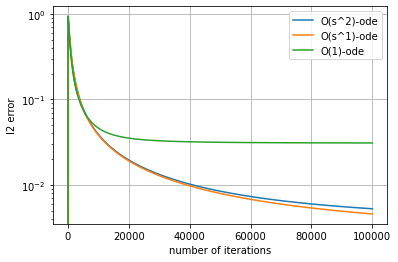

In [13]:

diff2 = np.sqrt(((z_egdta - z_egode2[idx]) ** 2).sum(axis=1))
diff1 = np.sqrt(((z_egdta - z_egode1[idx]) ** 2).sum(axis=1))
diff0 = np.sqrt(((z_egdta - z_egode0[idx]) ** 2).sum(axis=1))

fig, ax = plt.subplots()
ax.plot(np.arange(len(diff2)), diff2, label="O(s^2)-ode")
ax.plot(np.arange(len(diff1)), diff1, label="O(s^1)-ode")
ax.plot(np.arange(len(diff0)), diff0, label="O(1)-ode")
ax.set_yscale("log")
ax.legend()
plt.grid(visible=True)
ax.set_ylabel("l2 error")
ax.set_xlabel("number of iterations")
fig.savefig("actual_cubeloss_osr.png", dpi=80, bbox_inches="tight")
